# Samsung AI Challenge for Scientific Discovery 
dacon: https://dacon.io/competitions/official/235789/overview/description

## 01. Install and Load required packages 
- install: rdkit, Mordred, LightAutoML

In [51]:
# install LightAutoML
!pip install -U lightautoml

     |████████████████████████████████| 262 kB 29.4 MB/s 
     |████████████████████████████████| 67.4 MB 28 kB/s 
     |████████████████████████████████| 424 kB 63.6 MB/s 
     |████████████████████████████████| 232 kB 59.6 MB/s 
     |████████████████████████████████| 24.1 MB 2.4 kB/s 
     |████████████████████████████████| 302 kB 58.0 MB/s 
     |████████████████████████████████| 98 kB 9.0 MB/s 
     |████████████████████████████████| 204 kB 77.5 MB/s 
     |████████████████████████████████| 1.2 MB 49.0 MB/s 
     |████████████████████████████████| 804.1 MB 2.5 kB/s 
     |████████████████████████████████| 2.8 MB 34.0 MB/s 
     |████████████████████████████████| 37.1 MB 51 kB/s 
     |████████████████████████████████| 2.8 MB 45.9 MB/s 
     |████████████████████████████████| 895 kB 51.0 MB/s 
     |████████████████████████████████| 636 kB 59.9 MB/s 
     |████████████████████████████████| 3.3 MB 37.8 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |█████████████

In [52]:
# install rdkti
!pip install kora -q
import kora.install.rdkit

     |████████████████████████████████| 57 kB 4.8 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 


In [53]:
# install mordred
!pip install mordred

     |████████████████████████████████| 128 kB 34.8 MB/s 
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176723 sha256=9c560a5b50f33676a824ec5fa7d086844202a35f57a7791281b22972652ae1e4
  Stored in directory: /root/.cache/pip/wheels/02/c0/2e/e7e3d63b431777712ebc128bc4deb9ac5cb19afc7c1ea341ec
Successfully built mordred


In [54]:
# for lightAutoML
!pip install numpy==1.21.2

     |████████████████████████████████| 15.7 MB 194 kB/s 
ERROR: Operation cancelled by user


Before run next cell, It needs "Runtime restart"

In [33]:
# Python libraries
import random
import os
import sys
import time
import copy
import zipfile
import argparse
import warnings; warnings.filterwarnings("ignore")

# DS libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Modeling libraries
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.autograd import Variable

# Feature extraction for SMILES libraries (rdkit, mordred)
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from mordred import Calculator, descriptors

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [34]:
# Setup constants
MY_PATH = '/content/drive/MyDrive/Colab_Notebooks/dacon/'
DATA_DIR = MY_PATH + 'data/'
SUBMISSION_DIR = MY_PATH + 'submission/'
CLEANED_DIR = MY_PATH + 'cleaned/'
MODEL_DIR = MY_PATH + 'model/'

N_THREADS = 4
N_FOLDS = 10
RANDOM_STATE = 42
TEST_SIZE = 0.1
TIMEOUT = 4*3600
TARGET_NAME = 'ST1'

In [35]:
# Fix random seed for reproducibility
np.random.seed(RANDOM_STATE)
# torch.set_num_threads(N_THREADS)

## 02. Data Pre-processing

In [36]:
# Extract datasets from zip
my_zip = zipfile.ZipFile(DATA_DIR + "Samsung AI Challenge for Scientific Discovery_data.zip")
if not (os.path.isdir('./dataset')):
  os.makedirs(os.path.join('dataset'))
my_zip.extractall('dataset')
my_zip.close()

In [37]:
# Load datasets
train_original = pd.read_csv('dataset/train.csv')
dev = pd.read_csv('dataset/dev.csv')
test = pd.read_csv('dataset/test.csv')

submission = pd.read_csv('dataset/sample_submission.csv')

In [38]:
# Copy train set for preprocessing
# train = train_original # pd.concat([train_original, dev], axis=0)
train = pd.concat([train_original, dev], axis=0)

train_original.shape, train.shape, dev.shape, test.shape

((30274, 4), (30345, 4), (71, 4), (602, 2))

In [39]:
# Create target label
train[TARGET_NAME] = train['S1_energy(eV)'] - train['T1_energy(eV)']
train

,uid,SMILES,S1_energy(eV),T1_energy(eV),ST1
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809,1.2938
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585,0.2032
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787,0.4633
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847,1.1054
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724,0.2243
...,...,...,...,...,...
66,dev_66,N#Cc1cc(-c2ccc(N3c4ccccc4Oc4ccccc43)cc2)c(-c2c...,2.1939,2.1846,0.0093
67,dev_67,CC1(C)c2ccccc2N(c2ccc(-c3nc4ccc(N5c6ccccc6C(C)...,2.3537,2.3371,0.0166
68,dev_68,Cc1cc(-n2c3ccc(C(C)(C)C)cc3c3cc(C(C)(C)C)ccc32...,2.1364,2.1260,0.0104
69,dev_69,Cc1cc(-n2c3ccccc3c3ccccc32)cc(C)c1B1c2ccccc2B(...,2.2650,2.2511,0.0139


In [8]:
# Create bin to startify split
min = np.amin(train[TARGET_NAME])
max = np.amax(train[TARGET_NAME])

bins     = np.linspace(start=min, stop=max, num=5)
y_binned = np.digitize(train[TARGET_NAME], bins, right=True)

# train, test split
tr_data, te_data = train_test_split(train, 
                                    test_size=TEST_SIZE, 
                                    stratify=y_binned, 
                                    random_state=RANDOM_STATE)

print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(tr_data.shape, te_data.shape))

Data splitted. Parts sizes: tr_data = (27310, 5), te_data = (3035, 5)


In [9]:
##################
### Train data ###
##################

import math

# Extract pattern fingerprint from SMILES
def extract_fp(dataframe):
  fps = []
  for index, row in dataframe.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    fp = Chem.rdmolops.PatternFingerprint(mol)
    fps.append(fp)

  return fps

train_fps = extract_fp(tr_data)

In [10]:
##################
### Test data ###
##################

# Extract pattern fingerprint from SMILES
test_fps = extract_fp(te_data)

In [11]:
# Convert data to numpy array

def convert_np_array(fps):
  np_fps = []
  for fp in fps:
    arr = np.zeros((0,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

  return np.array(np_fps)

np_train_fps_array = convert_np_array(train_fps)
np_test_fps_array = convert_np_array(test_fps)

In [12]:
# Create preprocessed train dataset

def preprocessd_data(dataframe, np_fps_array):
  temp = dataframe.reset_index(drop=True)
  fps_df = pd.DataFrame(np_fps_array)
  result_df = pd.concat([temp, fps_df], axis=1, ignore_index=True)
  result_df.columns = list(temp.columns) + [str(i) for i in range(0, len(result_df.columns) - dataframe.shape[1])]
  result_df = result_df.set_index(dataframe.index)
  return result_df

result_train_df = preprocessd_data(tr_data, np_train_fps_array)

In [13]:
# Create preprocessed test dataset

result_test_df = preprocessd_data(te_data, np_test_fps_array)

In [14]:
print("Train data:", result_train_df.shape)
print("Test data:", result_test_df.shape)

Train data: (27310, 2053)
Test data: (3035, 2053)


#### Choice Section: Add baseline prediciton & mordred data

Option1: Add mordred features

In [36]:
# Load train mordred features
mordred_train = pd.read_csv(CLEANED_DIR + "Train_mordred_concat.csv")

# Object data to null
def train_float(x):
  try:
    x = float(x)
  except ValueError:
    x = np.nan
  return x

temp2 = mordred_train.dtypes == 'object'
object_columns = list(temp2[temp2 == True].index)
object_columns.remove('uid'); object_columns.remove('SMILES')

for column_name in object_columns:
  mordred_train[column_name] = mordred_train[column_name].apply(train_float)

# Drop columns that have null larger than 1000
drop_columns = list(mordred_train.isnull().sum()[mordred_train.isnull().sum() > 1000].index)
mordred_train = mordred_train.drop(drop_columns, axis=1)

# Drop columns with zero sum
temp = mordred_train.iloc[:, :].sum() == 0
zerosum_columns = list(temp[temp == True].index)
mordred_train = mordred_train.drop(zerosum_columns, axis=1)

# Cast boolean to int
mordred_train['Lipinski'] = mordred_train['Lipinski'].astype(int)
mordred_train['GhoseFilter'] = mordred_train['GhoseFilter'].astype(int)

# Drop columns not necessary
mordred_train = mordred_train.drop(['SMILES', 'S1_energy(eV)', 'T1_energy(eV)', 'ST1'], axis=1)

In [37]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(mordred_train.iloc[:, 1:])
temp_df = pd.DataFrame(imp_mean.transform(mordred_train.iloc[:, 1:]), columns=mordred_train.columns[1:])
temp_df['uid'] = mordred_train['uid']

In [38]:
temp_train = pd.merge(result_train_df, temp_df, how='left', on='uid')
temp_test = pd.merge(result_test_df, temp_df, how='left', on='uid')

print(temp_train.shape)
print(temp_test.shape)
temp_train.head(3)

(27310, 3403)
(3035, 3403)


,uid,SMILES,S1_energy(eV),T1_energy(eV),ST1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,train_1052,Cc1ncc2c(n1)CCCC2Nc1ccc(Br)cn1,4.1382,3.4569,0.6813,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016121,0.016805,0.009271,0.020610,0.442411,11.0,6.0,0.833333,0.454545,239.282783,5.392317,21.0,4.615121,5.451038,6.318968,7.173958,8.045909,8.908018,9.782054,10.647589,11.523123,112.465779,3.761200,0.0,5.068904,0.000000,6.580639,0.000000,8.186186,0.000000,9.839109,52.436038,318.048009,9.354353,722.0,28.0,100.0,116.0,5.416667,4.138889
1,train_22556,O=S(=O)(/C=C/c1cccc(Cl)c1)Nc1ccc(OCc2cccc(Cl)c...,3.6135,3.0783,0.5352,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.012616,0.007002,0.010863,0.006392,0.476451,17.0,9.0,0.888889,0.470588,361.936784,5.906891,30.0,4.962845,5.758902,6.613384,7.421178,8.274102,9.087834,9.938903,10.756604,11.606170,132.419921,4.110874,0.0,5.416100,0.000000,6.892642,0.000000,8.440960,0.000000,10.022647,62.883223,433.030620,9.622903,2561.0,37.0,142.0,158.0,8.979167,6.083333
2,train_25104,O=S(=O)(N[C@@H](c1ccccc1)c1cccs1)c1ccccc1F,4.9480,3.7549,1.1931,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007619,0.006314,0.006383,0.000000,0.423936,10.0,5.0,1.000000,0.500000,283.389982,5.643856,25.0,4.795791,5.638355,6.523562,7.387090,8.279190,9.151121,10.045811,10.921847,11.817575,122.560343,3.931826,0.0,5.252273,2.397895,6.771936,4.442651,8.381832,6.293419,10.039809,70.511641,347.044999,9.379595,1131.0,34.0,120.0,140.0,7.118056,5.041667


In [39]:
X_train = temp_train.iloc[:, 5:]
y_train = temp_train['ST1']

X_test = temp_test.iloc[:, 5:]
y_test = temp_test['ST1']

Option2: Normalization & PCA

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

pca = PCA(n_components=200)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [44]:
result_train_df = pd.concat([temp_train.iloc[:, :5], pd.DataFrame(X_train, columns=[str(n) for n in range(X_train.shape[1])])], axis=1)
result_test_df = pd.concat([temp_test.iloc[:, :5], pd.DataFrame(X_test, columns=[str(n) for n in range(X_train.shape[1])])], axis=1)

Option3: Add basline prediction

In [45]:
base_df = pd.read_csv(MY_PATH + 'base_prediction2.csv')

## for PCA ##
base_std = StandardScaler()
base_train = base_std.fit_transform(base_df[['base_prediction']])
base_df = base_df[['uid']]
base_df['base_prediction'] = base_train

base_df.head()

,uid,base_prediction
0,train_0,1.850841
1,train_1,-1.486460
2,train_2,-0.721184
3,train_3,1.364598
4,train_4,-1.640320


In [46]:
result_train_df = pd.merge(result_train_df, base_df[['uid', 'base_prediction']], how='left', on='uid')
result_test_df = pd.merge(result_test_df, base_df[['uid', 'base_prediction']], how='left', on='uid')

Option4: Add mordred prediciton (It's not recommended)

In [15]:
mordred_df = pd.read_csv(MY_PATH + 'mordred_prediction.csv')
mordred_df.head()

,uid,SMILES,S1_energy(eV),T1_energy(eV),ST1,mordred_pred
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809,1.2938,1.396260
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585,0.2032,0.202599
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787,0.4633,0.521910
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847,1.1054,1.249385
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724,0.2243,0.215575


In [16]:
result_train_df = pd.merge(result_train_df, mordred_df[['uid', 'mordred_pred']], how='left', on='uid')
result_test_df = pd.merge(result_test_df, mordred_df[['uid', 'mordred_pred']], how='left', on='uid')

In [17]:
result_train_df.head(10)

,uid,SMILES,S1_energy(eV),T1_energy(eV),ST1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,mordred_pred
0,train_1052,Cc1ncc2c(n1)CCCC2Nc1ccc(Br)cn1,4.1382,3.4569,0.6813,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.586314
1,train_22556,O=S(=O)(/C=C/c1cccc(Cl)c1)Nc1ccc(OCc2cccc(Cl)c...,3.6135,3.0783,0.5352,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.684933
2,train_25104,O=S(=O)(N[C@@H](c1ccccc1)c1cccs1)c1ccccc1F,4.9480,3.7549,1.1931,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.227727
3,train_11213,CCn1c(SCC(=O)c2cc(C)n(-c3ccc4c(c3)OCO4)c2C)nc2...,3.9074,3.2471,0.6603,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.607643
4,train_23303,CCCN(CCC)C(=O)CC(C(=O)O)c1cccc(Cl)c1,5.2158,4.1335,1.0823,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.086086
5,train_28314,COC(=O)COc1ccc(/C=C/C2=[N+]3C(=C(c4ccc(N5CCCCC...,2.7093,1.4086,1.3007,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.288638
6,train_14473,CCOCCNCc1c(C)nc2sc(C)cn12,5.0875,3.8922,1.1953,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.340849
7,train_23943,CCOC(=O)[C@@H](Br)[C@@H](O)CC(C)C,5.4688,5.0080,0.4608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.489319
8,train_4845,O=C(O)C1CCCN(C(=O)Nc2ccncc2F)C1,4.9162,4.1429,0.7733,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.675462
9,train_4510,CC(O)Cc1nc2n(n1)CCN(C)C2,5.6963,4.8009,0.8954,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...

## 03. Modeling: LightAutoML & Training

In [18]:
# Setput task
task = Task('reg', 'mae')

sklearn doesn't support in general case mae and will not be used.


In [19]:
# Setup roles
roles = {'target': TARGET_NAME,
         'drop': ['uid', 'SMILES', 'T1_energy(eV)', 'S1_energy(eV)']
         }

In [20]:
lgb_params = {
    'metric': 'RMSE',
    'lambda_l1': 1e-07, 
    'lambda_l2': 2e-07, 
    'num_leaves': 42, 
    'feature_fraction': 0.55, 
    'bagging_fraction': 0.9, 
    'bagging_freq': 3, 
    'min_child_samples': 19,
    'num_threads': 4
}

cb_params = {
    'num_trees': 7000, 
    'od_wait': 1200, 
    'learning_rate': 0.02, 
    'l2_leaf_reg': 64, 
    'subsample': 0.83, 
    'random_strength': 17.17, 
    'max_depth': 6, 
    'min_data_in_leaf': 10, 
    'leaf_estimation_iterations': 3,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'bootstrap_type': 'Bernoulli',
    'leaf_estimation_method': 'Newton',
    'random_seed': 42,
    "thread_count": 4
}

In [22]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params = {'use_algos': [['lgb', 'cb']]}, # LGBM and CatBoost algos only
                       lgb_params = {'default_params': lgb_params, 'freeze_defaults': False}, # LGBM params
                       cb_params = {'default_params': cb_params, 'freeze_defaults': False}, # CatBoost params
                       verbose = 2 # Available values: 0,1,2,3 (from less detailed to more)
                      )

RD = ReportDeco(output_path = 'tabularAutoML_model_report')
automl_rd = RD(automl)

oof_pred = automl_rd.fit_predict(result_train_df, roles = roles)

Start automl preset with listed constraints:
- time: 14400 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (27310, 2054)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 14264.321302652359 secs
Start fitting Selector_LightGBM ...

===== Start working with fold 0 for Selector_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.0117056
[200]	valid's l2: 0.00838398
[300]	valid's l2: 0.00803854
[400]	valid's l2: 0.00786409
[500]	valid's l2: 0.00775643
[600]	valid's l2: 0.00769332
[700]	valid's l2: 0.00763761
[800]	valid's l2: 0.00757851
[900]	valid's l2: 0.00754231
[1000]	valid's l2: 0.00750879
[1100]	valid's l2: 0.00747931
[1200]	valid's l2: 0.00745281
Did not meet early stopping. Best iteration is:
[1200]	valid's l2: 0.00745281
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightG

Model Lvl_0_Pipe_0_Mod_1_CatBoost failed during ml_algo.fit_predict call.

catboost/private/libs/options/catboost_options.cpp:566: Newton leaves estimation method is not supoprted for MAE loss function


Time left 12935.140268325806

Automl preset training completed in 1464.87 seconds.
CPU times: user 43min 34s, sys: 12.7 s, total: 43min 47s
Wall time: 24min 35s


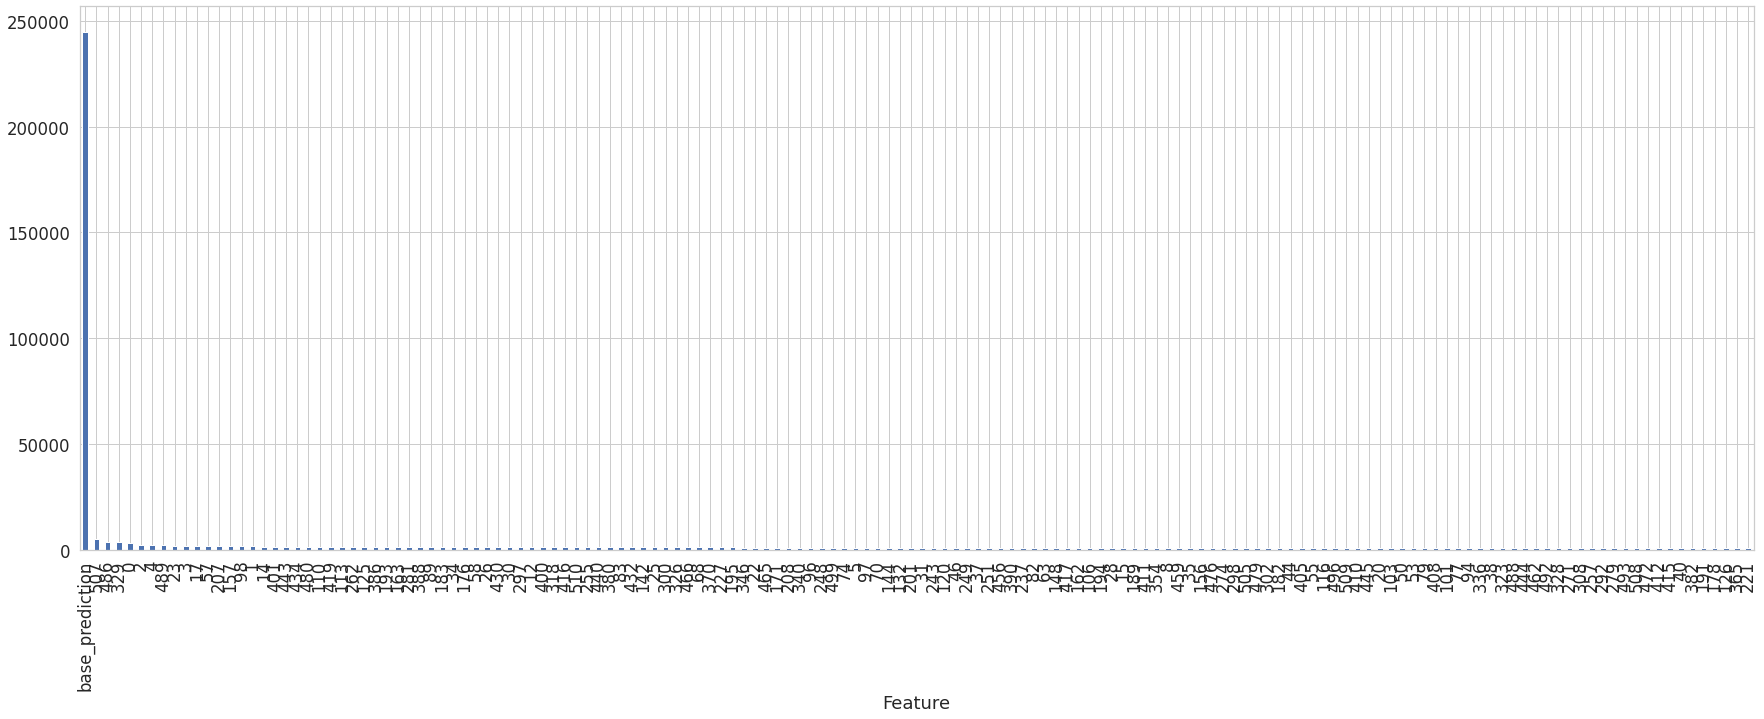

In [88]:
# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'][:150].plot.bar(figsize = (30, 10), grid = True)

In [89]:
fast_fi

,Feature,Importance
0,base_prediction,244645.915842
1,507,5319.102582
2,486,3692.493595
3,329,3550.219395
4,0,3289.993994
...,...,...
508,104,485.062597
509,169,465.082399
510,252,453.312005
511,485,432.550797


In [ ]:
fast_fi.to_csv(CLEANED_DIR + "feature_importance_rdkit.csv", index=False)

## 04. Evaluation

In [23]:
# test dataset
%%time

te_pred = automl_rd.predict(result_test_df)
print('Prediction for te_data:\n{}\nShape = {}'
              .format(te_pred, result_test_df.shape))

Prediction for te_data:
array([[1.1103655 ],
       [0.79445136],
       [0.8231899 ],
       ...,
       [1.422333  ],
       [0.18291506],
       [0.932507  ]], dtype=float32)
Shape = (3035, 2054)
CPU times: user 11.8 s, sys: 273 ms, total: 12 s
Wall time: 9 s


In [24]:
print('HOLDOUT score: {}'.format(mean_absolute_error(result_test_df[TARGET_NAME].values, te_pred.data[:, 0])))
# 0.12049271030939047: only add baseline
# 0.060298210780053006: append baseline + mordred prediction
# 0.12885181858612835: using PCA(n=512) + baseline
# 0.1298484152929718:  using mordred feature + PCA(n=200) + baseline 
# 0.06332532318191993:  Add mordred predition

HOLDOUT score: 0.06332532318191993


In [31]:
dev
dev[TARGET_NAME] = dev['S1_energy(eV)'] - dev['T1_energy(eV)']

dev_fps = [] 

# Extract pattern fingerprint from SMILES
for index, row in dev.iterrows() : 
  mol = Chem.MolFromSmiles(row['SMILES'])
  fp = Chem.rdmolops.PatternFingerprint(mol)

  dev_fps.append(fp)

# Convert data to numpy array
np_dev_fps = []

for fp in dev_fps:
  arr = np.zeros((0,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  np_dev_fps.append(arr)

np_dev_fps_array = np.array(np_dev_fps)

# Create preprocessed train dataset
dev_temp = dev.reset_index(drop=True)
dev_fps_df = pd.DataFrame(np_dev_fps_array)
result_dev_df = pd.concat([dev_temp, dev_fps_df], axis=1, ignore_index=True)
result_dev_df.columns = list(dev_temp.columns) + [str(i) for i in range(0, len(result_dev_df.columns)-5)]
result_dev_df = result_dev_df.set_index(dev.index)

In [ ]:
# dev dataset
%%time

dev_pred = automl_rd.predict(result_dev_df)
print('HOLDOUT score: {}'.format(mean_absolute_error(result_dev_df[TARGET_NAME].values, dev_pred.data[:, 0])))

## 05. Prediction & Submission

In [25]:
# Extract pattern fingerprint from SMILES
train_fps = extract_fp(train)

# Convert data to numpy array
np_train_fps_array = convert_np_array(train_fps)

# Create preprocessed train dataset
result_train_df = preprocessd_data(train, np_train_fps_array)

In [22]:
# temp_train = pd.merge(result_train_df, temp_df, how='left', on='uid')
# X_train = temp_train.iloc[:, 5:]

# #### Option: Normalization ####
# std = StandardScaler()
# X_train = std.fit_transform(X_train)
# #### Option: PCA ####
# pca = PCA(n_components=512)
# X_train = pca.fit_transform(X_train)

# result_train_df = pd.concat([temp_train.iloc[:, :5], pd.DataFrame(X_train, columns=[str(n) for n in range(X_train.shape[1])])], axis=1)

In [26]:
# base_df = pd.read_csv(MY_PATH + 'base_prediction2.csv')
mordred_df = pd.read_csv(MY_PATH + 'mordred_prediction.csv')

# ## for PCA ##
# base_std = StandardScaler()
# base_train = base_std.fit_transform(base_df[['base_prediction']])
# t = base_df[['uid']]
# t['base_prediction'] = base_train
# result_train_df = pd.merge(result_train_df, t, how='left', on='uid')

# result_train_df = pd.merge(result_train_df, base_df[['uid', 'base_prediction']], how='left', on='uid')
result_train_df = pd.merge(result_train_df, mordred_df[['uid', 'mordred_pred']], how='left', on='uid')
result_train_df

,uid,SMILES,S1_energy(eV),T1_energy(eV),ST1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,mordred_pred
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809,1.2938,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.396260
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585,0.2032,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.202599
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787,0.4633,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.521910
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847,1.1054,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.249385
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724,0.2243,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.215575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30340,dev_66,N#Cc1cc(-c2ccc(N3c4ccccc4Oc4ccccc43)cc2)c(-c2c...,2.1939,2.1846,0.0093,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
30341,dev_67,CC1(C)c2ccccc2N(c2ccc(-c3nc4ccc(N5c6ccccc6C(C)...,2.3537,2.3371,0.0166,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000
30342,dev_68,Cc1cc(-n2c3ccc(C(C)(C)C)cc3c3cc(C(C)(C)C)ccc32...,2.1364,2.1260,0.0104,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.193635
30343,dev_69,Cc1cc(-n2c3ccccc3c3ccccc32)cc(C)c1B1c2ccccc2B(...,2.2650,2.2511,0.0139,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0

In [28]:
# Retrain model
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params = {'use_algos': [['lgb', 'cb']]}, # LGBM and CatBoost algos only
                       lgb_params = {'default_params': lgb_params, 'freeze_defaults': False}, # LGBM params
                       cb_params = {'default_params': cb_params, 'freeze_defaults': False}, # CatBoost params
                       verbose = 1 # Available values: 0,1,2,3 (from less detailed to more)
                      )

oof_pred = automl.fit_predict(result_train_df, roles = roles)

Model Lvl_0_Pipe_0_Mod_1_CatBoost failed during ml_algo.fit_predict call.

catboost/private/libs/options/catboost_options.cpp:566: Newton leaves estimation method is not supoprted for MAE loss function


CPU times: user 47min 51s, sys: 11.3 s, total: 48min 2s
Wall time: 26min 56s


In [39]:
# Extract pattern fingerprint from SMILES
test_fps = extract_fp(test)

# Convert data to numpy array
np_test_fps_array = convert_np_array(test_fps)

# Create preprocessed train dataset
result_test_df = preprocessd_data(test, np_test_fps_array)

In [31]:
# #### for mordred features ####
# # Load train mordred features
# mordred_test = pd.read_csv(CLEANED_DIR + "Test_mordred_concat.csv")

# # Object data to null
# for column_name in object_columns:
#   mordred_test[column_name] = mordred_test[column_name].apply(train_float)

# # Drop columns that have null larger than 1000
# mordred_test = mordred_test.drop(drop_columns, axis=1)

# # Drop columns with zero sum
# mordred_test = mordred_test.drop(zerosum_columns, axis=1)

# # Cast boolean to int
# mordred_test['Lipinski'] = mordred_test['Lipinski'].astype(int)
# mordred_test['GhoseFilter'] = mordred_test['GhoseFilter'].astype(int)

# # Drop columns not necessary
# mordred_test = mordred_test.drop(['SMILES'], axis=1)

In [32]:
# test_temp_df = pd.DataFrame(imp_mean.transform(mordred_test.iloc[:, 1:]), columns=mordred_test.columns[1:])
# test_temp_df['uid'] = mordred_test['uid']

In [33]:
# temp_test = pd.merge(result_test_df, test_temp_df, how='left', on='uid')

# print(temp_test.shape)
# temp_test.head(3)

(602, 3400)


,uid,SMILES,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,test_0,COc1ccc(S(=O)(=O)NC2CCN(C3CCCCC3)CC2)c(C)c1C,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.015046,0.014061,0.008500,0.007108,0.508627,15.0,8.0,0.875000,0.466667,365.470636,5.807355,28.0,4.919981,5.771441,6.658011,7.523481,8.414274,9.285541,10.178198,11.052840,11.946725,129.750493,4.043051,0.00000,5.379897,0.000000,6.924612,0.000000,8.556606,0.000000,10.231604,61.135771,380.213364,6.555403,1814.0,43.0,136.0,160.0,9.090278,5.736111
1,test_1,CC(CCCC1CCC2C3=C(CC[C@]12C)[C@@]1(C)CC[C@H](C)...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.023179,0.015104,0.012432,0.011513,0.707191,15.0,8.0,0.875000,0.466667,484.163948,6.087463,34.0,5.198497,6.107023,7.063904,7.995980,8.956351,9.898927,10.863355,11.812282,12.780107,145.676426,4.234107,0.00000,5.680173,2.397895,7.327123,4.844187,9.070273,7.050123,10.866643,82.470523,428.401816,5.161468,2706.0,64.0,180.0,224.0,12.777778,6.305556
2,test_2,C[C@@H]1C[C@@H]1c1ccc2c(c1)c(-c1ccc[nH]c1=O)c(...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.017237,0.015136,0.008510,0.013346,0.515492,13.0,7.0,0.857143,0.461538,422.664064,6.321928,40.0,5.313206,6.192362,7.125283,8.031710,8.971956,9.893791,10.838777,11.770486,12.718618,156.856189,4.394449,1.94591,5.783825,4.110874,7.354362,6.167516,9.011524,8.170469,10.717103,93.656032,511.137734,8.663351,3567.0,61.0,202.0,244.0,12.868056,7.513889


In [34]:
# X_test = temp_test.iloc[:, 2:]

# X_test = std.transform(X_test)

# X_test = pca.transform(X_test)

# result_test_df = pd.concat([temp_test.iloc[:, :2], pd.DataFrame(X_test, columns=[str(n) for n in range(X_test.shape[1])])], axis=1)

In [35]:
# base_df = pd.read_csv(SUBMISSION_DIR + 'dacon_baseline4.csv')
# base_df = base_df.rename(columns={'ST1_GAP(eV)':'base_prediction'})

# ## for PCA ##
# base_test = base_std.transform(base_df[['base_prediction']])
# t = base_df[['uid']]
# t['base_prediction'] = base_test

mordred_df = pd.read_csv(SUBMISSION_DIR + 'morderd1.csv')
mordred_df = mordred_df.rename(columns={'ST1_GAP(eV)':'mordred_pred'})

In [40]:
# baseline prediction
# result_test_df = pd.merge(result_test_df, base_df[['uid', 'base_prediction']], how='left', on='uid')

#### for PCA ####
# result_test_df = pd.merge(result_test_df, t, how='left', on='uid') 

#### for only use mordred features (not use PCA) ####
result_test_df = pd.merge(result_test_df, mordred_df[['uid', 'mordred_pred']], how='left', on='uid')

In [41]:
print(result_train_df.shape)
print(result_test_df.shape)

(30345, 2054)
(602, 2051)


In [46]:
# Inference test dataset
%%time
# result_test_df['ST1'] = 0
test_pred = automl.predict(result_test_df)

CPU times: user 3.34 s, sys: 27.1 ms, total: 3.37 s
Wall time: 2.77 s


In [ ]:
result_train_df['ST1'].describe()

count    30345.000000
mean         0.848647
std          0.365624
min          0.000000
25%          0.576700
50%          0.875600
75%          1.089300
max          3.512900
Name: ST1, dtype: float64

In [47]:
# Create submission file
submission['ST1_GAP(eV)'] = test_pred.data[:, 0]
submission.loc[submission['ST1_GAP(eV)'] < 0, 'ST1_GAP(eV)'] = 0
submission.to_csv(SUBMISSION_DIR + "sub14.csv", index=False)

Experiment: 조금 더해보자

In [44]:
base_df = pd.read_csv(MY_PATH + 'base_prediction2.csv')
t = pd.merge(train, base_df[['uid', 'base_prediction']], how='left', on='uid')

In [46]:
t['diff'] = t['ST1'] - t['base_prediction']
t['abs_diff'] = abs(t['diff'])

In [ ]:
t.sort_values(by='abs_diff')[:30]

In [28]:
import pandas as pd

MY_PATH = '/content/drive/MyDrive/Colab_Notebooks/dacon/'
SUBMISSION_DIR = MY_PATH + 'submission/'
submission = pd.read_csv(SUBMISSION_DIR + "sub7.csv")

In [29]:
submission

,uid,ST1_GAP(eV)
0,test_0,0.783750
1,test_1,1.814742
2,test_2,1.062234
3,test_3,0.720262
4,test_4,1.272226
...,...,...
597,test_597,0.152219
598,test_598,0.135324
599,test_599,0.326517
600,test_600,0.432831


In [30]:
submission.loc[submission['ST1_GAP(eV)'] > 1.3, 'ST1_GAP(eV)'] += 0.1
submission.loc[submission['ST1_GAP(eV)'] > 1.5, 'ST1_GAP(eV)'] += 0.1

In [31]:
submission

,uid,ST1_GAP(eV)
0,test_0,0.783750
1,test_1,2.014741
2,test_2,1.062234
3,test_3,0.720262
4,test_4,1.272226
...,...,...
597,test_597,0.152219
598,test_598,0.135324
599,test_599,0.326517
600,test_600,0.432831


In [32]:
submission.to_csv(SUBMISSION_DIR + "sub16.csv", index=False)

## 06. Concatenated Data (Baseline + My)

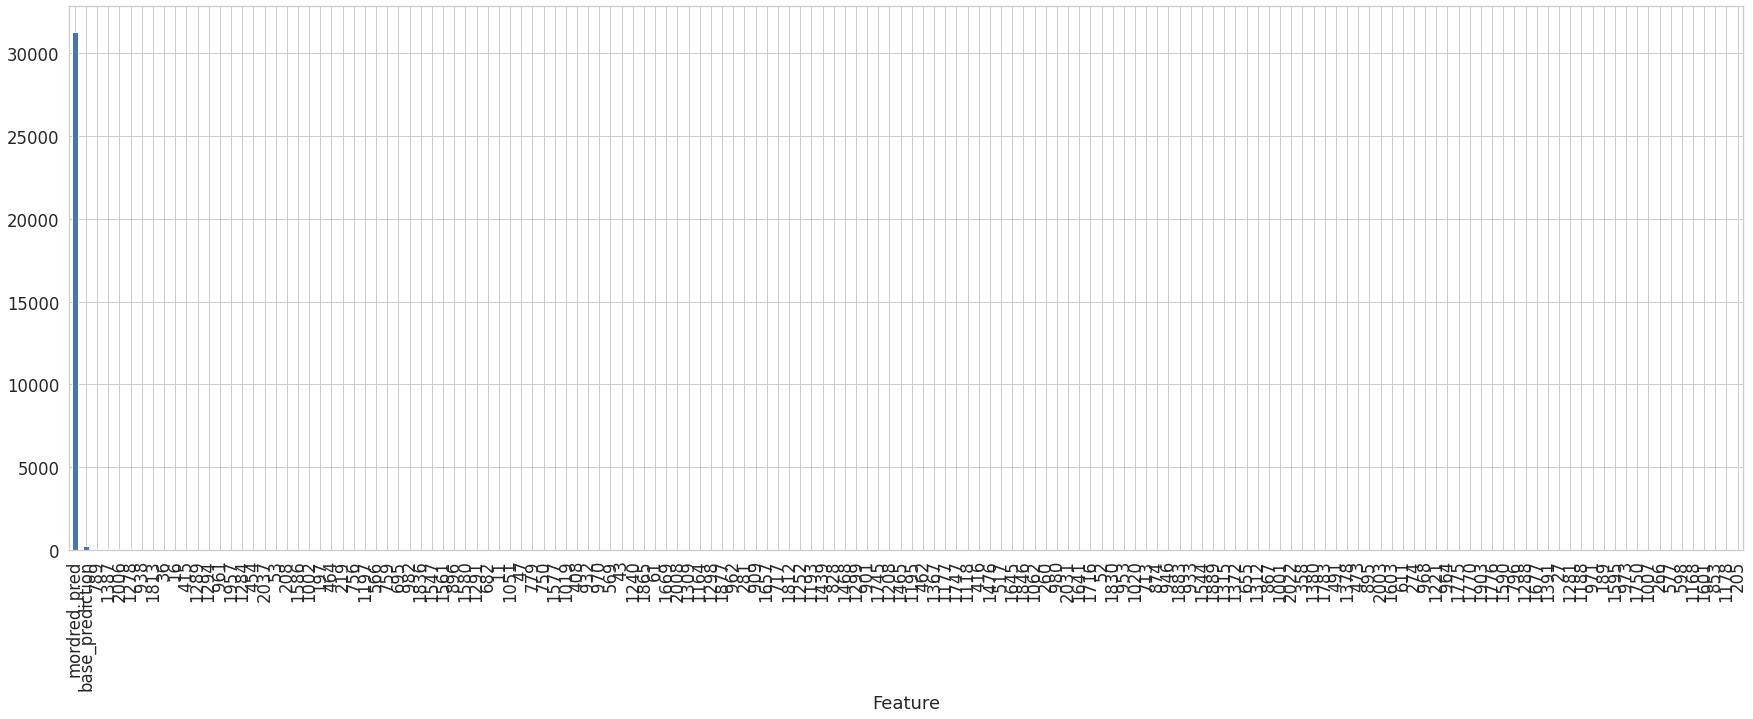

In [67]:
# Fast feature importances calculation
RD = ReportDeco(output_path = 'tabularAutoML_model_report')
automl_rd = RD(automl)
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'][:150].plot.bar(figsize = (30, 10), grid = True)

In [68]:
fast_fi[:100]

,Feature,Importance
0,mordred_pred,31276.780651
1,base_prediction,218.629952
2,789,48.138182
3,1387,42.470433
4,2006,37.138752
...,...,...
95,1020,3.476807
96,713,3.463985
97,874,3.452949
98,946,3.436522


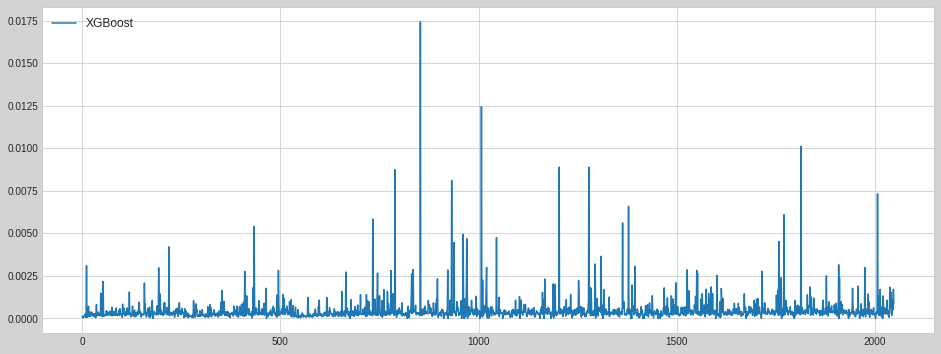

In [ ]:
a1 = model1.feature_importances_

plt.style.use('seaborn-whitegrid') 
plt.figure(figsize=(16, 6), facecolor='lightgray')

plt.plot(a1,label='XGBoost') 

plt.legend(fontsize=12, loc=2)
plt.show()